In [27]:
# Importaciones
import random
import requests as rq
from bs4 import BeautifulSoup
import re
import networkx as nx
import pickle

# Abro la base de datos con mis paginas almacenadas y la cargo en memoria
with open("data.pickle", "rb") as f:
     guardados = ((pickle.load(f)))

# Paginas almacenadas
print(len(guardados))

4046


In [2]:

#clases
class Nodo():
    
    # quiero que cuando lo imprima me salga el nombre del objeto (limito los caracteres oara el grafico)
    def __repr__(self) -> str:
        return '%.9s' % self.nombre
    
    #cuando se incializa un nodo se crea en el grafico, se le da un nombre, la url de su pagina de wikipedia y se le crea una lista con todos los links dentro de ella
    def __init__(self, nombre) -> None:
        self.nombre = nombre
        # acá se van a almacenar las urls internas
        self.palabras = set()
        self.parsePage(nombre)
    
    #metodo que va a fijarse si dos nodos tienen conexion, osea si uno referencia al otro (opcional a usar)
    def estaEn(self, nodo):
        if self.nombre.lower() in nodo.palabras:
            self.addEdge(nodo)
            
     
    #parsea con bs4 la pagina de wikipedia que le pases, obteniendo los hipervinculos dentro
    def parsePage(self,nombre):
                
        #el prefijo para siguientes busquedas
        prefijo_wiki = "https://es.wikipedia.org/wiki/"
        url = prefijo_wiki + nombre

        # Me fijo si esta ne mi base de datos de urls
        if self.nombre in guardados.keys():
            page = guardados[self.nombre]
        else:
            page = rq.get(url)
            guardados[self.nombre] = page

        #la parseo en un objeto
        soup = BeautifulSoup(page.content, "html.parser")
        
        #armo una lista con los terminos que yo quiero, en este caso todos los links que refertencian a otra pagina dentro de la wikipedia
        links = soup.find_all('a', attrs={"href": re.compile("^/wiki/")})

        #selecciono a partir de que links me va a interesar revisar (es arbitrario para reducir los link que no me importan, como los de discusion e idiomas del articulo)
        limite_inferior = 30

        ## LIMPIEZA DE DATOS ##
        
        #obtengo el texto y lo cargo en el set
        for i in links[limite_inferior:]:
            self.palabras.add(i.get_text().lower().replace(" ","_")) # Hay que hacer que no sea caps sensitive y eliminar los espacios para poder usarlos en urls
        
        #remuevo los resultados vacios, el try hace que el remove no me explote el programa
        try:
            self.palabras.remove('')
        except KeyError:
            pass
        
        # remuevo estos links que no me interesan
        try:
            self.palabras.remove("limitación_de_responsabilidad")
        except KeyError:
            pass
        
        # el about usa tampoco me interesa
        try:
            self.palabras.remove("acerca_de_wikipedia")
        except KeyError:
            pass
        
        # filtro aquellos resultados que empiezan con wikipedia y los del isbn, uso regex
        for i in list(self.palabras):
            if re.match(r"^wikipedia", i) or re.match(r"^isbn", i):
                self.palabras.remove(i)
        


                
    

        



homo_sapiens
_etnia
pueblos_semitas
wilhelm_marr
cita requerida
categorías
porfirio
nla
oración
filósofos_de_la_antigua_grecia_del_siglo_iii
aristóteles
cráter_lunar_aristóteles
verde
verde_amarillento
lima_(color)
chartreuse_(color)
anexo:colores
azul_bondi
antracita
acero
puerta_rápida
etano
9780123750891
etileno
densidad_electrónica
pd
irlandés
imelda_may
eficiencia_energética
convención_marco
ciclo_termodinámico
gnd
centrales_termosolares
ciclo_rankine
motor_stirling
españa
américa_latina
estado_libre_asociado
política_de_puerto_rico
organización_territorial_de_estados_unidos
cláusula_territorial
congreso_de_los_estados_unidos
distrito_congresual
cámara_de_representantes_de_japón
aat
siglas
radar
ondas_electromagnéticas
electrodinámica
átomos
demócrito_de_abdera
calco
ndl
calco
compendium_of_chemical_terminology_(iupac_gold_book)
_radio_atómico
po
pavia
ticinesa
cherasco
alcalde
jefe_de_gobierno
ministro_presidente
jefatura_de_gobierno
funcionarios_administrativos
control_de_autori

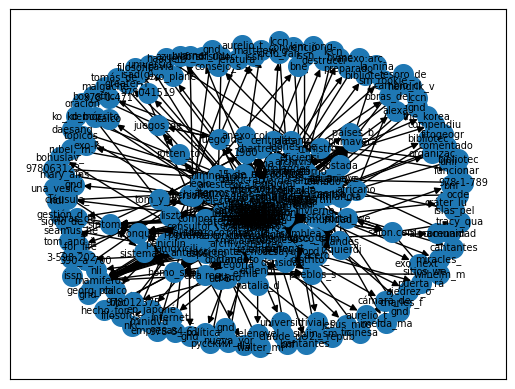

In [26]:
######### Ejemplo con encadenamiento ###############

#lista que va a tener todos los nodos del grafico
nodos = set()
# lista que contiene los vertices
vertices = list()



#nodo central
nodo_maestro = Nodo("mamiferos")
# lo agrego a la lista con todos los nodos
nodos.add(nodo_maestro)


# obtengo un nodo aleatorio
nodo = Nodo(list(nodo_maestro.palabras)[random.randrange(0,len(nodo_maestro.palabras))])
# nodo que me va a servir para saber que nodo referencia a cual
nodo_anterior = nodo_maestro
# voy a ejecutar 50 "queries"
for i in range(300):
    # lo agrego a la lista d enodos
    nodos.add(nodo)
    print(nodo.nombre)
    # agrego el link entre el ndodo buscado y el nodo de donde salió
    # si no esta vacio me va a servir para encontrar nuevos nodos
    if (len(nodo.palabras)>0):
        # checkeo con que otros nodos hay relacion (osea que esta en su lista de palabras)
        for i in nodos:
            if nodo.nombre in i.palabras and i.nombre != nodo.nombre: # no me interesa que se vincule consigo mismo
                vertices.append((nodo,i))
        # lo voy a usar para buscar mas nodos, por lo tanto lo tengo que guardar para luego vincularlo
        nodo_anterior = nodo
        # consigo un nuevo nodo
        nodo = Nodo(list(nodo_anterior.palabras)[random.randrange(0,len(nodo_anterior.palabras))]) # cambiar nodo_maestro por nodo
    else:
        # si elnodo esta vacio uso el anterior y no me intrrumpe la ejecucion del programa
        nodo =  Nodo(random.choice(list(nodo_anterior.palabras)))
    vertices.append((nodo_anterior, nodo)) #REVISAR ESTO, pq no funciona sin?
    



    
# creo el grafo
grafo = nx.DiGraph()
grafo.add_nodes_from(list(nodos))
grafo.add_edges_from(vertices)
nx.draw_networkx(grafo, with_labels=True, node_size=200, font_size = 7)
print(vertices)

# # para actualizar la lista de paginas (DEJAR COMENTADO)
# with open("data.pickle", "wb") as f:
#     pickle.dump(guardados,f)

parmesano
clarín
control_d
piamonte
nli
pollo_al_
margarita
cortapizz
nueva_mon
patrimoni
978889055
salsas
mozzarell
pizza_ira
pizza_est
irán
vico_eque
comida_ca
champiñon
la_repubb
leudado
al_forno
página/12
borbones
nkc
crónica_d
sushi
catania
leudado
patrimoni
wikcionar
milán
patrimoni
gluten
turín
viva
salami
fugazzett
orégano
pizza_de_
unesco
vico_eque
nli
sam_panop
tomate_sa
085404486
britannic
reino_del
nueva_mon
978193149
pato
nápoles
978-88541
pizza_de_
pizza_a_d
aceitunas
viva
espagueti
gastronom
milán
pizza_est
085404486
hawái
jamón
fainá
calzone
pizza_al_
pizza_de_
estilo_sa
salsa
port'alba
bne
cocina_me
fugazzett
cocina_me
la_nación
provenza
plato
brotes_de
harina_de
978889055
_franquic
banchero
wikcionar
gravy
estilo_de
salsa_de_
marcas
provenza
cebolla
chicago_t
978193149
darío_i_e
diversas_
cocina_me
patrimoni
nápoles
licencia_
pizza_de_
gluten


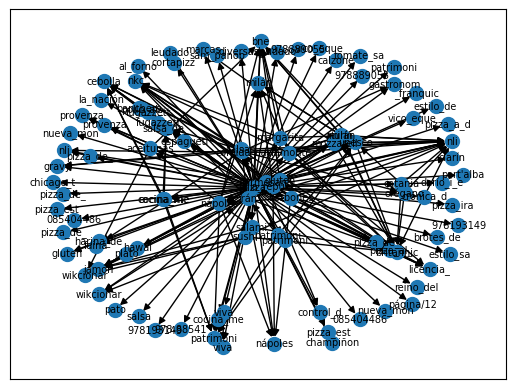

In [23]:
####### EJEMPLO ramificacion CENTRAL ##########

# Mi centro del grafo, de acá vana salir todas las paginas
nodo_central = Nodo("pizza")

# Nodos
n1 = list()

# veritces
v = list()

# ramas
for i in range(100):
    nodo = Nodo(random.choice(list(nodo_central.palabras)))
    print(nodo)
    # checkeo las conexiones con otros nodos
    for j in n1:
        if nodo.nombre in j.palabras:
            v.append((j, nodo))
    # lo agrego a los nodos a dibujar
    n1.append(nodo)



# los uno todos con el nodo central, que es de donde salen
for nodo in n1:
    v.append((nodo_central, nodo))
    
grafo = nx.DiGraph()
grafo.add_nodes_from(list(n1))
grafo.add_edges_from(v)
nx.draw_networkx(grafo, with_labels=True, node_size=100, font_size = 7)


# # para actualizar la lista de paginas (DEJAR COMENTADO)
# # para actualizar la lista de paginas
# with open("data.pickle", "wb") as f:
#     pickle.dump(guardados,f)


se me jijean los jijos
